# Use case

In [1]:
import pandas as pd
from ast import literal_eval

data_raw = pd.read_csv("../data/stocks.csv")
data_raw

,year,ticker,returns_yoy,returns_mean,returns_std,returns_kurt,returns_skew,current_assets_chg,total_assets_chg,current_liabilities_chg,...,gross_profit_chg,operating_income_chg,ebit_chg,ebitda_chg,net_income_chg,cash_flow_chg,gics_sector,gics_industry_group,gics_industry,gics_sub_industry
0,1984,ABT,-0.023327,-0.000081,0.015751,1.137280,0.150682,0.199012,0.123607,0.192155,...,0.091034,0.119551,0.119551,0.142322,0.158099,0.185255,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
1,1984,ADM,-0.026099,-0.000104,0.020297,3.388723,0.910988,-0.010240,0.016783,-0.442166,...,0.090505,0.239521,0.239521,0.184024,0.068358,0.085822,Consumer Staples,"Food, Beverage & Tobacco",Food Products,Agricultural Products
2,1984,AIR,0.632523,0.002427,0.021781,4.852271,1.239041,0.328328,0.233089,-0.053046,...,0.165023,0.072245,0.072245,0.087333,0.605367,0.327884,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense
3,1984,AP,0.254065,0.001079,0.015319,6.334656,1.158865,0.473669,0.463316,0.484195,...,0.723608,-1.143189,-4.665928,4.393316,-4.411381,2.389767,Materials,Materials,Metals & Mining,Steel
4,1984,APA,0.354090,0.001460,0.023034,1.213794,0.306496,-0.103468,-0.083883,0.176250,...,-0.125055,-0.006917,-0.058889,0.037832,-0.028582,0.121321,Energy,Energy,"Oil, Gas & Consumable Fuels",Oil & Gas Exploration & Production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16034,2018,XYL,0.438349,0.001772,0.010812,2.641754,-0.159363,0.011106,0.052770,0.262727,...,0.094543,0.197802,0.163511,0.149693,0.658610,0.327869,Industrials,Capital Goods,Machinery,Industrial Machinery
16035,2018,YUM,0.304004,0.001204,0.010132,8.515445,0.365575,-0.518548,-0.222369,-0.139550,...,0.074187,-0.168417,0.040901,-0.024227,0.150746,-0.204243,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure",Restaurants
16036,2018,ZBH,-0.105038,-0.000394,0.013195,3.860412,-0.492598,-0.030100,-0.072546,-0.219370,...,-0.006197,-0.958179,-0.260979,-0.170304,-1.209064,-0.605724,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
16037,2018,ZEN,0.534857,0.002201,0.022210,3.768737,0.040686,0.664630,1.093239,0.494517,...,0.379028,0.299418,0.299418,0.366408,0.283363,0.346874,Information Technology,Software & Services,Software,Application Software


In [2]:
CATEGORICAL_VAR = 'gics_sub_industry'
NUMERICAL_VARS = data_raw.select_dtypes('number').columns

In [3]:
# top artists with the most songs in our dataset
top50 = data_raw[CATEGORICAL_VAR].value_counts().iloc[:50]
top50

Industrial Machinery                          1000
Oil & Gas Exploration & Production             667
Aerospace & Defense                            634
Specialty Chemicals                            553
Oil & Gas Equipment & Services                 526
Health Care Equipment                          487
Packaged Foods & Meats                         378
Apparel Retail                                 357
Oil & Gas Storage & Transportation             325
Construction Machinery & Heavy Trucks          296
Steel                                          291
Construction & Engineering                     272
Oil & Gas Drilling                             253
Building Products                              250
Life Sciences Tools & Services                 226
Pharmaceuticals                                221
Auto Parts & Equipment                         219
Household Products                             203
Trading Companies & Distributors               194
Apparel, Accessories & Luxury G

<div style='height:20px'></div>

__Defining the initial clusters__

The initial clusters include all categories of variable CATEGORICAL_VAR with at least MIN_SAMPLE_SIZE instances

In [4]:
data = data_raw[data_raw[CATEGORICAL_VAR].isin(top50.index)]
initial_clusters = pd.Series(top50.index)

initial_clusters

0                           Industrial Machinery
1             Oil & Gas Exploration & Production
2                            Aerospace & Defense
3                            Specialty Chemicals
4                 Oil & Gas Equipment & Services
5                          Health Care Equipment
6                         Packaged Foods & Meats
7                                 Apparel Retail
8             Oil & Gas Storage & Transportation
9          Construction Machinery & Heavy Trucks
10                                         Steel
11                    Construction & Engineering
12                            Oil & Gas Drilling
13                             Building Products
14                Life Sciences Tools & Services
15                               Pharmaceuticals
16                        Auto Parts & Equipment
17                            Household Products
18              Trading Companies & Distributors
19           Apparel, Accessories & Luxury Goods
20                  

<div style='height:20px'></div>

__Maximum Mean Discrepancy__

__implementation__: https://github.com/emanuele/kernel_two_sample_test  
__pvalue bug fix__: https://github.com/smkia/kernel_two_sample_test/commit/601725d7abb60b2b7f258d702b76ac6c80785aee

In [5]:
import numpy as np
from sklearn.metrics import pairwise_kernels

def mmd(X, Y):
    # code from functon above
    m = len(X)
    n = len(Y)
    
    # stack all instances together
    XY = np.vstack([X, Y])
    
    # compute the kernel matrix using RBF kernel function
    K = pairwise_kernels(XY, metric='rbf')
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    
    # compute the MMD² biased statistic
    #mmd2b = 1.0 / (m * m) * (Kx.sum() - Kx.diagonal().sum()) + \
    #        1.0 / (n * n) * (Ky.sum() - Ky.diagonal().sum()) - \
    #        2.0 / (m * n) * Kxy.sum()
    #return mmd2b
    
    # compute the MMD² unbiased statistic
    mmd2u = 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
            1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
            2.0 / (m * n) * Kxy.sum()
    return np.sqrt(max(0., mmd2u))

dissimilarity = mmd

Note that this can take negative values. [https://papers.nips.cc/paper/6300-examples-are-not-enough-learn-to-criticize-criticism-for-interpretability.pdf] argue that this is due to overfitting.

<div style='height:20px'></div>

<div style='height:20px'></div>

__Standardizing the Data__

Normalizing the data before feeding it to a learning algorithm is a good practice in most cases. This is especially valid before the calculation of the kernel matrix using RBF. By standardizing the numerical variables, we make sure that each numerical dimension has variance 1 and contributes similarly to the l2 norm contained in the RBF function.

In [6]:
numerical_data = data.loc[:, NUMERICAL_VARS]
numerical_data = (numerical_data - numerical_data.mean()) / numerical_data.std()
data.loc[:, NUMERICAL_VARS] = numerical_data

data

/home/quebralim/anaconda3/envs/Py37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,year,ticker,returns_yoy,returns_mean,returns_std,returns_kurt,returns_skew,current_assets_chg,total_assets_chg,current_liabilities_chg,...,gross_profit_chg,operating_income_chg,ebit_chg,ebitda_chg,net_income_chg,cash_flow_chg,gics_sector,gics_industry_group,gics_industry,gics_sub_industry
0,-2.339479,ABT,-0.297523,-0.288523,-0.566053,-0.394888,0.142391,0.282443,0.069903,0.153648,...,-0.035600,0.080912,0.029792,0.044127,0.108770,0.131663,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
2,-2.339479,AIR,1.186352,1.145268,-0.148167,-0.097754,0.994005,0.679314,0.482058,-0.445177,...,0.176392,0.051424,-0.012805,-0.035869,0.307575,0.254242,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense
3,-2.339479,AP,0.330084,0.374426,-0.595998,0.020810,0.931269,1.125367,1.348770,0.866864,...,1.776835,-0.706200,-4.279307,6.228304,-1.922308,2.026281,Materials,Materials,Metals & Mining,Steel
4,-2.339479,APA,0.556391,0.592518,-0.061378,-0.388769,0.264312,-0.645869,-0.711210,0.114805,...,-0.654732,0.002080,-0.130885,-0.107881,0.025792,0.076716,Energy,Energy,"Oil, Gas & Consumable Fuels",Oil & Gas Exploration & Production
5,-2.339479,ASH,-0.323125,-0.291785,-0.509015,-0.251784,-0.093693,-0.234069,-0.480176,-0.211707,...,0.044052,-0.028771,-0.128654,-0.125326,-1.159877,-0.859802,Materials,Materials,Chemicals,Specialty Chemicals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,1.457586,XRX,-0.214705,-0.224177,-0.620877,-0.136480,-0.161397,-0.642269,-0.648507,0.138772,...,-0.390970,0.164255,0.012090,-0.071121,0.416881,-0.079013,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals"
16034,1.457586,XYL,0.747029,0.770645,-0.908299,-0.274557,-0.100212,-0.294243,-0.196769,0.325999,...,-0.025545,0.129689,0.069375,0.054851,0.331241,0.254229,Industrials,Capital Goods,Machinery,Industrial Machinery
16035,1.457586,YUM,0.443072,0.445914,-0.955423,0.195235,0.310540,-1.919755,-1.232552,-0.656437,...,-0.083869,-0.098589,-0.041029,-0.198161,0.105501,-0.203082,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure",Restaurants
16036,1.457586,ZBH,-0.482394,-0.467176,-0.743208,-0.177086,-0.360960,-0.420703,-0.668529,-0.851371,...,-0.314184,-0.590876,-0.312858,-0.410668,-0.498917,-0.548126,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment


<div style='height:20px'></div>

__Dissimilarity Matrix__

In [7]:
dissimilarity_matrix = pd.DataFrame(index=initial_clusters.index, columns=initial_clusters.index, dtype=float)
for i in range(len(initial_clusters)):
    sample_i = data[data[CATEGORICAL_VAR]==initial_clusters[i]][NUMERICAL_VARS]
    for j in range(i+1,len(initial_clusters)):
        sample_j = data[data[CATEGORICAL_VAR]==initial_clusters[j]][NUMERICAL_VARS]
        dissimilarity_matrix.iloc[j,i] = dissimilarity(sample_i, sample_j)
minimum = dissimilarity_matrix.min().min()
if minimum < 0: dissimilarity_matrix.min().min()

In [8]:
dissimilarity_matrix.round(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.038,0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.027,0.264,0.045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.239,0.083,0.208,0.223,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.089,0.240,0.066,0.094,0.201,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.073,0.331,0.094,0.089,0.295,0.122,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.154,0.207,0.129,0.140,0.135,0.135,0.216,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.254,0.158,0.216,0.242,0.143,0.213,0.287,0.187,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.144,0.157,0.111,0.130,0.094,0.114,0.206,0.059,0.149,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2d PCA Visualization

In [9]:
dissimilarity_complete = dissimilarity_matrix.copy()
dissimilarity_complete.iloc[np.identity(len(dissimilarity_matrix), bool)] = 0
dissimilarity_complete[dissimilarity_complete.isna()] = dissimilarity_complete.T[dissimilarity_complete.isna()]
dissimilarity_complete

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.283015,0.038033,0.026871,0.239262,0.089450,0.072565,0.153669,0.253998,0.144087,...,0.197622,0.171847,0.032507,0.085880,0.103050,0.000000,0.127331,0.038523,0.080918,0.125246
1,0.283015,0.000000,0.253592,0.264407,0.083208,0.240136,0.330907,0.207424,0.157916,0.156506,...,0.173039,0.148695,0.280928,0.198765,0.368259,0.284228,0.237839,0.268259,0.241737,0.225217
2,0.038033,0.253592,0.000000,0.045258,0.208378,0.066465,0.094086,0.129474,0.215561,0.110958,...,0.162341,0.135122,0.046857,0.056948,0.126793,0.030027,0.094917,0.016590,0.088209,0.131086
3,0.026871,0.264407,0.045258,0.000000,0.223195,0.093602,0.088965,0.140238,0.241567,0.130138,...,0.188505,0.157274,0.048805,0.067867,0.130765,0.026138,0.118491,0.049227,0.060335,0.102586
4,0.239262,0.083208,0.208378,0.223195,0.000000,0.201013,0.295339,0.134789,0.142545,0.093925,...,0.107065,0.093126,0.226478,0.145421,0.329296,0.244855,0.187341,0.229130,0.220294,0.203982
5,0.089450,0.240136,0.066465,0.093602,0.201013,0.000000,0.121660,0.134706,0.212928,0.114142,...,0.157915,0.127846,0.073625,0.075089,0.135543,0.090041,0.121233,0.070014,0.107595,0.146929
6,0.072565,0.330907,0.094086,0.088965,0.295339,0.121660,0.000000,0.215835,0.286724,0.205744,...,0.251297,0.218373,0.099467,0.148339,0.065542,0.067688,0.165740,0.056400,0.102935,0.159407
7,0.153669,0.207424,0.129474,0.140238,0.134789,0.134706,0.215835,0.000000,0.187168,0.059016,...,0.070581,0.076464,0.116079,0.057613,0.240602,0.162560,0.103615,0.150840,0.173568,0.177439
8,0.253998,0.157916,0.215561,0.241567,0.142545,0.212928,0.286724,0.187168,0.000000,0.148769,...,0.137643,0.106623,0.248841,0.174567,0.323219,0.254476,0.150532,0.217575,0.240956,0.256426
9,0.144087,0.156506,0.110958,0.130138,0.093925,0.114142,0.205744,0.059016,0.148769,0.000000,...,0.063671,0.036677,0.123148,0.026262,0.236274,0.150539,0.104412,0.135654,0.145621,0.149048


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set()

In [11]:
dissimilarity_2d = PCA(2).fit_transform(dissimilarity_complete)
dissimilarity_2d = pd.DataFrame(dissimilarity_2d, columns=['PCA0', 'PCA1'], index=initial_clusters)

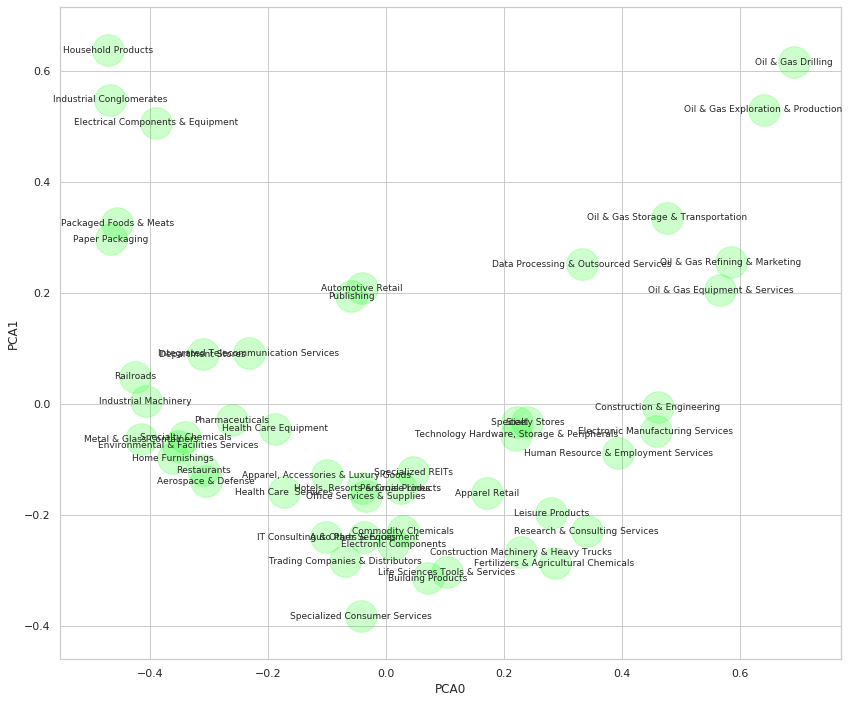

In [12]:
sns.set(style='whitegrid')
fig, ax = plt.subplots()
dissimilarity_2d.plot('PCA0', 'PCA1', kind='scatter', ax=ax, figsize=(14,12), s=1000, c='#00FF0033')

for k, v in dissimilarity_2d.iterrows():
    ax.annotate(k, v, ha='center', va='center', fontsize='9')

<div style='height:20px'></div>

__Hierarchical Clustering__

The next step is to find the minimum distance between two clusters in the dissimilarity matrix and join them into one new cluster. The older 2 clusters get removed from the matrix, and a new entry for the new cluster is added.

In [13]:
def matrix_argmin(matrix):
    column_smallest = matrix.min().idxmin()
    row_smallest = matrix[column_smallest].idxmin()
    return row_smallest, column_smallest

In [14]:
cluster1,cluster2 = matrix_argmin(dissimilarity_matrix)
print('The smallest value is',dissimilarity_matrix.loc[cluster1,cluster2],'between',cluster1,'and',cluster2)

The smallest value is 0.0 between 23 and 0


In [15]:
linkage = pd.DataFrame(columns=['child_1','child_2','distance','size','categories'])
linkage.index.name = 'cluster_id'
linkage

while len(dissimilarity_matrix) > 1:
    # new cluster id
    new_cluster_id = len(initial_clusters) + len(linkage)

    # find 2 child linkage whose dissimilarity is minimum
    child_1_id, child_2_id = matrix_argmin(dissimilarity_matrix)
    new_distance = dissimilarity_matrix.loc[child_1_id, child_2_id]

    # clean up dissimilarity_matrix
    dissimilarity_matrix = dissimilarity_matrix.drop(index=[child_1_id, child_2_id])
    dissimilarity_matrix = dissimilarity_matrix.drop(columns=[child_1_id, child_2_id])
    dissimilarity_matrix.loc[new_cluster_id, :] = np.nan
    dissimilarity_matrix.loc[:, new_cluster_id] = np.nan
    
    # concatenate categories
    child_1_categories = [initial_clusters.iloc[child_1_id]] if child_1_id in initial_clusters.index else linkage.loc[child_1_id, 'categories']
    child_2_categories = [initial_clusters.iloc[child_2_id]] if child_2_id in initial_clusters.index else linkage.loc[child_2_id, 'categories']
    new_categories = child_1_categories + child_2_categories

    # identify instances of the new cluster
    new_cluster_mask = data[CATEGORICAL_VAR].isin(new_categories)
    new_cluster_instances = data[new_cluster_mask][NUMERICAL_VARS]
    
    # sum size
    new_size = len(new_cluster_instances)
    
    # update the dissimilarity matrix with new distances to the new cluster
    for c in dissimilarity_matrix.columns[:-1]:
        categories = [initial_clusters.iloc[c]] if c in initial_clusters.index else linkage.loc[c, 'categories']
        cluster_mask = data[CATEGORICAL_VAR].isin(categories)
        cluster_instances = data[cluster_mask][NUMERICAL_VARS]
        dissimilarity_matrix.loc[new_cluster_id, c] = dissimilarity(new_cluster_instances, cluster_instances)

    # add cluster to linkage dataframe
    linkage.loc[new_cluster_id, :] = [child_1_id, child_2_id, new_distance, new_size, new_categories]

The resultant linkage matrix allows the visualization of categories in a dendrogram, representing connections and distances between clusters of categories

In [16]:
linkage

,child_1,child_2,distance,size,categories
cluster_id,,,,,
50,23,0,0,1175,"[Metal & Glass Containers, Industrial Machinery]"
51,33,9,0,445,"[Leisure Products, Construction Machinery & He..."
52,43,13,0,382,"[Specialized Consumer Services, Building Produ..."
53,41,14,0,360,"[Research & Consulting Services, Life Sciences..."
54,35,16,0,362,"[Commodity Chemicals, Auto Parts & Equipment]"
55,37,32,0,291,"[IT Consulting & Other Services, Office Servic..."
56,42,34,0,280,"[Home Furnishings, Department Stores]"
57,51,39,0,581,"[Leisure Products, Construction Machinery & He..."
58,50,45,0,1297,"[Metal & Glass Containers, Industrial Machiner..."


<div style='height:20px'></div>

__Visualizing the hierarchy dendrogram__

Finally, we build a dendrogram from the information from the hierachical linkage. A scipy implementation is available for this.

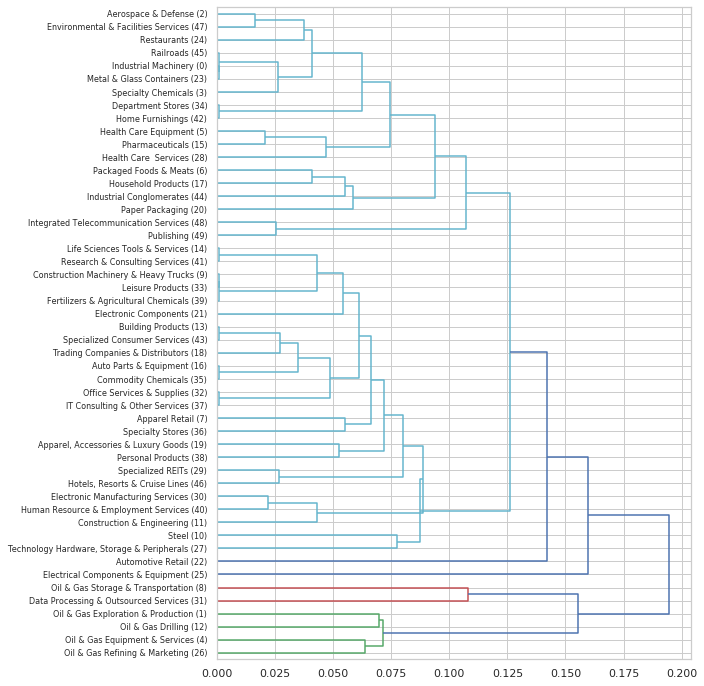

In [17]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

linkage_adjusted = linkage.iloc[:,:4].astype(float)
linkage_adjusted.loc[:'distance'].replace(0., 0.001, inplace=True)
labels = [c+' ('+str(i)+')' for i,c in enumerate(initial_clusters)]
plt.figure(figsize=(8.5, 12))
dend = shc.dendrogram(linkage_adjusted, orientation='right', labels=labels, distance_sort=True)